## Imports

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, recall_score, make_scorer, roc_auc_score, auc, PrecisionRecallDisplay
import pandas as pd
import numpy as np
from raw_data import save_all_files, concat_df
from tqdm import tqdm
import pickle

## Load the data

Loads the required datasets from google cloud. Then selects only relevant columns and saves it into /data/_year_.pkl.

In [2]:
save_all_files()

Get a coffee ;) 


100%|██████████| 5/5 [00:00<00:00, 2505.26it/s]

You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You successfully downloaded 0 of the 5 files.


## Concatenate data from different years to one dataframe

In [4]:
df = concat_df()
df

100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


,DIABETE3,SEX,_AGEG5YR,EDUCA,_BMI5,_BMI5CAT,GENHLTH,PHYSHLTH,_TOTINDA,EXERANY2,...,SMOKDAY2,_RFSMOK3,DRNKANY5,ALCDAY5,AVEDRNK2,DRNK3GE5,_RFBING5,CVDSTRK3,CVDINFR4,CVDCRHD4
0,3.0,2.0,9.0,4.0,1855.0,2.0,4.0,88.0,2.0,2.0,...,1.0,2.0,1.0,103.0,2.0,88.0,1.0,2.0,2.0,2.0
1,3.0,1.0,3.0,3.0,3529.0,4.0,4.0,12.0,2.0,2.0,...,1.0,2.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
2,3.0,2.0,14.0,6.0,1695.0,1.0,2.0,88.0,1.0,1.0,...,3.0,1.0,1.0,101.0,1.0,88.0,1.0,2.0,2.0,2.0
3,3.0,2.0,14.0,4.0,2579.0,3.0,3.0,88.0,9.0,NaN,...,NaN,1.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
4,4.0,2.0,7.0,3.0,4346.0,4.0,5.0,25.0,1.0,1.0,...,3.0,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380042,1.0,2.0,11.0,2.0,1842.0,1.0,4.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380043,3.0,2.0,2.0,5.0,2834.0,3.0,1.0,88.0,1.0,1.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380044,3.0,2.0,11.0,4.0,4110.0,4.0,4.0,88.0,9.0,NaN,...,3.0,1.0,1.0,202.0,2.0,88.0,1.0,2.0,2.0,2.0
2380045,3.0,1.0,7.0,5.0,2315.0,2.0,3.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0


## Data preparation

- [ ] feature selection
- [ ] data cleaning

In [5]:
# here the data cleaning and data preparation takes place
target_name = "DIABETE3"
feature_names = df.columns.values.tolist()
feature_names.remove(target_name)

# removed all nan values for decision tree to function
illegal_value_dict = {
    "SEX": [], 
    "_AGEG5YR": [14],
    "EDUCA": [9],
    "_BMI5": [], # nan (empty)
    "_BMI5CAT": [],
    "GENHLTH": [7, 9],
    "PHYSHLTH": [77, 88, 99],
    "_TOTINDA": [9],
    "EXERANY2": [7, 9],
    "SMOKE100": [7, 9],
    "SMOKDAY2": [7, 9],
    "_RFSMOK3": [9],
    "DRNKANY5": [7, 9],
   "ALCDAY5": [777, 999],
    "AVEDRNK2": [77, 99],
   "DRNK3GE5": [77, 99],
    "_RFBING5": [9],
    "CVDSTRK3": [7, 9],
    "CVDINFR4": [7, 9],
    "CVDCRHD4": [7, 9]
}

value_mapping = {
    "SEX": {1: 1, 2: 0}, # 1 = male, 0 = female
    # "_AGEG5YR": {},
    # "EDUCA": {}, # 1-6 ordinal categorical
    # "_BMI5": {}, # 1-999999
    # "_BMI5CAT": {}, # categorical
    # "GENHLTH": {}, # 1-5 ordinal categorical
    # "PHYSHLTH": {}, # 1-30
    "_TOTINDA": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "EXERANY2": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "SMOKE100": {1: 1, 2: 0}, # 1 = yes, 0 = no
    # "SMOKDAY2": {}, # 1 = "everyday", 2 = "some days", 3 = "not at all"
    "_RFSMOK3": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "DRNKANY5": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "ALCDAY5": {888: 0, }, # categorical # TODO
    # "AVEDRNK2": {}, # 1-76 continuous
    "DRNK3GE5": {88: 0}, # 0-76 continuous
    "_RFBING5": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "CVDSTRK3": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDINFR4": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDCRHD4": {1: 1, 2: 0} # 1 = yes, 0 = no
 }

feature_list = [
    "SEX", 
    "_AGEG5YR",
    "EDUCA", 
    "_BMI5", 
    "_BMI5CAT",
    "GENHLTH", 
    "PHYSHLTH",
    "_TOTINDA", 
    "EXERANY2", 
    "SMOKE100", 
    "SMOKDAY2", 
    "_RFSMOK3", 
    "DRNKANY5", 
    "ALCDAY5", 
    "AVEDRNK2", 
    "DRNK3GE5", 
    "_RFBING5", 
    "CVDSTRK3", 
    "CVDINFR4", 
    "CVDCRHD4"
]

renames = [
    "sex",
    "age",
   "education",
    "body_mass_index",
    "bmi_cat",
    "estimated_health",
    "bad_physhealth_days",
    "had_phys_activity",
    "any_exercise",
    "smoked_over_100",
    "smokes_daily",
    "is_smoker",
    "alcohol_past_30",
    "one_drink_per_day_month_last_30",
    "average_drinks",
    "more_than_5_drinks",
    "more_than_5_drinks_on_one_occasion",
    "had_stroke",
    "had_heart_attack",
    "had_angina"
]

# only include rows with diabetes = yes and no and select relevant columns
df_filtered = df.loc[df["DIABETE3"].isin([1, 3]), feature_list + [target_name]]

# filter out illegal values for each feature
for column, bad_value_list in tqdm(illegal_value_dict.items()):
    df_filtered = df_filtered[~df_filtered[column].isin(bad_value_list)]

# map values for each feature
for column, mapping in tqdm(value_mapping.items()):
    df_filtered[column] = df_filtered[column].map(mapping)

# rename label 1 = 1 = yes (has diabetes) | 3 = 0 = no (no diabetes)
df_filtered["DIABETE3"] = df_filtered["DIABETE3"].map({1: 1, 3: 0})
df_filtered.columns = renames + [target_name]
df_filtered

100%|██████████| 12/12 [00:00<00:00, 25.14it/s]


,sex,age,education,body_mass_index,bmi_cat,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,...,is_smoker,alcohol_past_30,one_drink_per_day_month_last_30,average_drinks,more_than_5_drinks,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
31,1,8.0,6.0,2585.0,3.0,2.0,2.0,1,1,1,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
35,0,5.0,5.0,2391.0,2.0,4.0,5.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
36,0,5.0,5.0,3411.0,4.0,4.0,15.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,1
37,0,9.0,4.0,2575.0,3.0,4.0,20.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
39,0,11.0,5.0,2146.0,2.0,3.0,2.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380029,0,1.0,5.0,1785.0,1.0,3.0,4.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380032,1,9.0,4.0,3119.0,4.0,4.0,30.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380035,1,1.0,4.0,NaN,NaN,1.0,2.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
2380039,1,3.0,6.0,4229.0,4.0,3.0,4.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0


In [6]:
selected_features = [
    "age",
    "body_mass_index",
    "estimated_health",
    "bad_physhealth_days",
    "had_phys_activity",
    "is_smoker",
]

feature_list = [feature for feature in renames if feature not in ['more_than_5_drinks','average_drinks', 'smokes_daily','one_drink_per_day_month_last_30', 'bmi_cat', 'education']]

df_filtered = df_filtered.loc[:, feature_list + [target_name]]

df_filtered

,sex,age,body_mass_index,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,is_smoker,alcohol_past_30,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
31,1,8.0,2585.0,2.0,2.0,1,1,1,0,1,0,0,0.0,0,0
35,0,5.0,2391.0,4.0,5.0,0,0,0,0,0,0,0,0.0,0,0
36,0,5.0,3411.0,4.0,15.0,0,0,1,0,0,0,0,0.0,0,1
37,0,9.0,2575.0,4.0,20.0,0,0,1,0,0,0,0,0.0,0,0
39,0,11.0,2146.0,3.0,2.0,1,1,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380029,0,1.0,1785.0,3.0,4.0,1,1,0,0,0,0,0,0.0,0,0
2380032,1,9.0,3119.0,4.0,30.0,0,0,0,0,0,0,0,0.0,0,0
2380035,1,1.0,NaN,1.0,2.0,1,1,0,0,1,0,0,0.0,0,0
2380039,1,3.0,4229.0,3.0,4.0,1,1,0,0,1,0,0,0.0,0,0


### Drop missing and bad input values

In [9]:
nan_amounts = [df_filtered[col].isnull().values.sum() for col in df_filtered.columns]
cols_with_nan_amounts = list(zip(df_filtered.columns, nan_amounts))
cols_with_nan_amounts.sort(key=lambda x: x[1], reverse=True)
cols_with_nan_amounts
# for col in df_filtered.columns:
#     nan_amounts.append()
#     print("\n")
#     print(f"Column {col} has the following values:")
#     print(df_filtered[col].value_counts())
#     print(f"... and {df_filtered[col].isnull().values.sum()} nan values:")
#     print()

[('body_mass_index', 31915),
 ('estimated_health', 11),
 ('bad_physhealth_days', 3),
 ('had_heart_attack', 1),
 ('sex', 0),
 ('age', 0),
 ('had_phys_activity', 0),
 ('any_exercise', 0),
 ('smoked_over_100', 0),
 ('is_smoker', 0),
 ('alcohol_past_30', 0),
 ('more_than_5_drinks_on_one_occasion', 0),
 ('had_stroke', 0),
 ('had_angina', 0),
 ('DIABETE3', 0)]

In [10]:
# drop na drops [NAN] of the rows...
df_prepared = df_filtered.dropna().reset_index(drop=True)
df_prepared.DIABETE3.value_counts()

0    573254
1    130768
Name: DIABETE3, dtype: int64

## Model training
- [ ] model selection
- [ ] train-test split (maybe before data prep)
- [ ] hyperparameter tuning
- [ ] more stuff

In [53]:
# used for GridSearchCV
param_grid = { 
    'n_estimators': [200, 500], # 500
    'max_features': ['sqrt', 'log2'], # 'auto' 
    'max_depth' : [4, 8], # 7,8
    'criterion' :['gini', 'entropy']
} # best for rfc RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=300, random_state=42)

# used for GridSearchCV / DecisionTreeClassifier
param_grid_dtc = {
    'max_features': ['sqrt', 'log2'], # 'auto'
    'max_depth' : [4, 15], # 7,8
    'criterion' :['gini', 'entropy']
} # best for

# used for GridSearchCV / ExtraTreesClassifier
param_grid_etc = {
    'n_estimators': np.arange(100, 500, 10), # 500
    'max_features': ['sqrt', 'log2'], # 'auto'
    'max_depth': np.arange(6, 32, 1),
    'criterion' :['gini', 'entropy']
}

# used for GridSearchCV / ExtraTreesClassifier
param_grid_hist = {
    'loss': ['log_loss'], # 500
    'learning_rate': np.arange(0.01, 0.5, 0.02),
    'max_iter': np.arange(100, 400, 100),
    'max_leaf_nodes': np.arange(3, 40, 2),
}

# used for RandomizedSearchCV
param_distributions = { 
    'n_estimators': np.arange(100, 500, 10), # 500
    'max_features': ['sqrt', 'log2'], # 'auto' 
    'max_depth' : np.arange(4, 15), # 7,8
    'criterion' :['gini', 'entropy']
} # best for RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=220, random_state=42)

my_recall_scorer = make_scorer(recall_score)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared[feature_list], df_prepared[target_name], test_size=0.2, random_state=41)

model = HistGradientBoostingClassifier(random_state=42)
# model = ExtraTreesClassifier(random_state=42)
CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_grid_hist, cv=4, n_jobs=2, scoring=my_recall_scorer, verbose=5)

### ATTENTION this takes up to 70 Minutes

In [58]:
CV_model.fit(X_train, y_train)
model = CV_model.best_estimator_
CV_model.best_score_

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'best_estimator_'

In [46]:
filename = "ExtraTreesClassifier.sav"
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
best_params = loaded_model.get_params()

X_train, X_test, y_train, y_test = train_test_split(df_prepared[feature_list], df_prepared[target_name], test_size=0.2, random_state=41)

best_model = ExtraTreesClassifier(**best_params)
best_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [62]:
# CV_model = best_model
y_predict = CV_model.predict(X_test)

# y_score = CV_model.predict_proba(X_test)[:, 1]
y_score = CV_model.decision_function(X_test)

score = accuracy_score(y_test, y_predict)
print(score)

matrix = confusion_matrix(y_test, y_predict, labels = [1,0])
print(matrix)

precision, recall, _, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_predict, labels= [1,0])
roc_auc_scores = roc_auc_score(y_true=y_test, y_score=y_score, labels= [1,0])

print(f"Precision for 'yes' = {precision[0]}")
print(f"Precision for 'no' = {precision[1]}")
print(f"recall for 'yes' = {recall[0]}")
print(f"recall for 'no' = {recall[1]}")
print(f"roc_auc_score = {roc_auc_scores}")

0.8256880082383438
[[  5956  20149]
 [  4395 110305]]
Precision for 'yes' = 0.5754033426722056
Precision for 'no' = 0.8455470893954957
recall for 'yes' = 0.2281555257613484
recall for 'no' = 0.9616826503923278
roc_auc_score = 0.8091603114442764


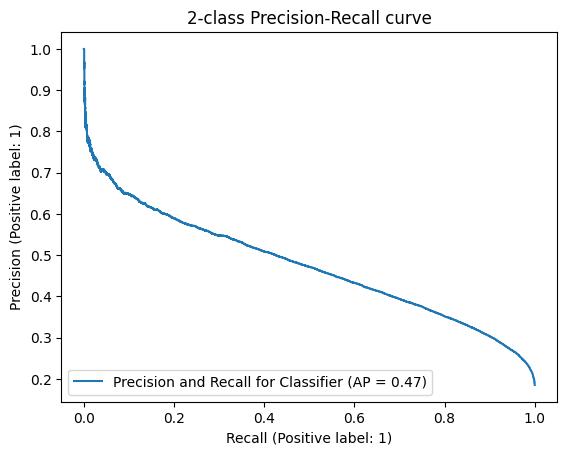

In [63]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="Precision and Recall for Classifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Save model

In [15]:
filename = "ExtraTreesClassifier.sav"
pickle.dump(model, open(filename, 'wb'))

### Load model

In [24]:
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
print(loaded_model.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [13]:
score = recall_score(y_test, y_predict)
print(score)

0.29005937559854433


In [ ]:
test = model.feature_importances_
z= list(zip(feature_list, test))
z.sort(key=lambda x: x[1], reverse=True)
z

## Use Model to predict user's diabetes probability

### Get user input

In [ ]:
# please input data: ...

# use data for diabetes proba
user_row = df_prepared.loc[[11], feature_list].reset_index(drop=True) # got a random index just as an example
probas = model.predict_proba(user_row)
print(user_row)
# label_meanings = (
#     "diabetes",
#     "diabetes during pregnancy",
#     "pre-diabetes or borderline diabetes",
#     "don't know",
#     "refused",
#     "BLANK"
# )
probas
# for l, p in probas.tolist():
#     print(f"With a probability of {round(p*100, 2)}% you (will) have result: {l}.")

### Make recommendations: What factors have the most significant impact on the user's diabetes probability?